## Machine Learning: Classification

Classification problem is when you have a dataset of objects belonging to a number of classes, and you need to build a model that will determine the class based on input features. Another way to put it: in regression you need to predict numberic variable, and in classiciation - categorical (mostly nominal). 

We distinguish between **binary** and **multiclass** classification, the former being a special case of the latter. However, any multi-class classification can be reduced to binary using one-vs-all approach, by building a set of binary classifiers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets

To begin with, let's build an artificial dataset with 2 input features for binary classification: 

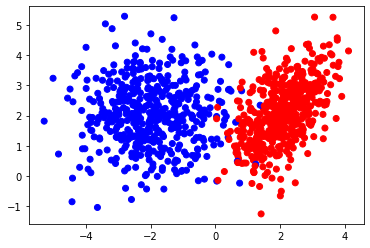

In [2]:
X,Y = sk.datasets.make_classification(
    n_samples=1000,n_features=2,random_state=13,
    n_informative=2,n_redundant=0,
    class_sep=2,n_clusters_per_class=1,flip_y=0)

plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
plt.show()

## Logistic Regression

Simplest binary classification algorithm is called **logistic regression**. It uses linear function to distinguish between classes $f_{W,b}(x)=Wx+b$, where $W$ - is weights matrix, $b$ - bias.

> **Important:** despite the name, logistic regression is a classification algorithm!

We can use sign of $f$ to decide which class of the object is given by the model. Since in our dataset $y_i\in\{0,1\}$, predicted value $y={1\over2}(\mathrm{sign} f(x)+1)$. We say that an **activation function** $\sigma(x)={1\over2}(\mathrm{sign}(x)+1)$, is used after linear function, i.e. $y=\sigma(f(x))$.

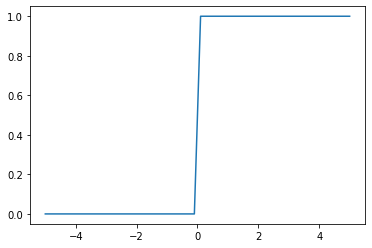

In [3]:
nx=np.linspace(-5,5)
plt.plot(nx,0.5*(np.sign(nx)+1))
plt.show()

However, sign function is not smooth, and in order to use gradient descent optimization we need our function to be continuous and differentiable. Thus, most often **sigmoid** is used as an activation function $\sigma(x)={1\over1+e^{-x}}$.

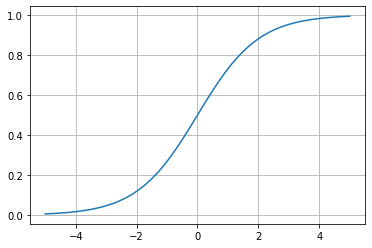

In [4]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.linspace(-5,5)
plt.plot(x,sigmoid(x))
plt.grid()
plt.show()

Let's use gradient descent:

In [5]:
W = np.random.normal(size=(2,))
b = np.random.normal(size=(1,))

def mse_loss(W,b):
  return np.average(np.square(sigmoid(np.matmul(X,W)+b)-Y))

mse_loss(W,b)

0.48613052654058275

We can try to compute the derivative for gradient descent numerically. Normally we do not do that, because it is computationally expensive, especially in the multi-dimensional case. But let's do it just for demo purposes, and define a function that will partially differentiate a given function `f`:

In [7]:
def d(f,x,dx=0.1):
    n = x.shape[0]
    r = np.zeros_like(x)
    for i in range(n):
        dxc = np.eye(n)[i]*dx
        r[i] = (f(x+dxc)-f(x))/dx
    return r

d(lambda x: mse_loss(x,b),W) # derivative w.r.t. dW

array([-0.46858171, -0.05336945])

Optimization loop looks the same as for regression:

In [17]:
W = np.random.normal(size=(2,))
b = np.random.normal(size=(1,))

eta = 0.1
n = len(X)
for i in range(100):
    print(f"({W} {b}) -> loss={mse_loss(W,b)}")
    #print(f"dldw={dldw}, dldb={dldb}, W={W}, b={b}")

    dldw = d(lambda x: mse_loss(x,b),W)
    dldb = d(lambda x: mse_loss(W,x),b)
    h = sigmoid(np.matmul(X,W)+b)
    W-=eta*dldw
    b-=eta*dldb


([-0.45959708  0.32284837] [2.10863054]) -> loss=0.4820546030449369
([-0.45173899  0.32153233] [2.10773515]) -> loss=0.4813945408725472
([-0.44387501  0.32008768] [2.10676805]) -> loss=0.4807300112272627
([-0.43599862  0.31851488] [2.10572938]) -> loss=0.48005949643019935
([-0.42810331  0.31681408] [2.10461912]) -> loss=0.479381475974702
([-0.42018262  0.31498511] [2.10343711]) -> loss=0.47869441497640036
([-0.41223004  0.31302751] [2.10218302]) -> loss=0.4779967526528874
([-0.40423902  0.31094049] [2.10085638]) -> loss=0.4772868906591996
([-0.39620297  0.30872296] [2.09945658]) -> loss=0.476563181104831
([-0.38811514  0.30637352] [2.09798284]) -> loss=0.47582391407335006
([-0.37996869  0.30389045] [2.09643423]) -> loss=0.4750673044567406
([-0.3717566   0.30127169] [2.09480966]) -> loss=0.4742914779030837
([-0.36347165  0.29851486] [2.09310786]) -> loss=0.47349445565776854
([-0.3551064  0.2956172] [2.0913274]) -> loss=0.4726741380544673
([-0.34665314  0.29257562] [2.08946666]) -> loss=

Let's see how the boundary between classes looks. Since we determine classes by the sign of $f(x)$, the boundary will be given by the equation $w_0x_0+w_1x_1+b = 0$, where $x_0,x_1$ - our input variables, $w_0, w_1, b$ - model parameters. Thus we can write the equation for the straight line by expressing $x_1$ w.r.t. $x_0$:
$$
x_1 = {-b\over w_1}- {w_0\over w_1}x_0
$$

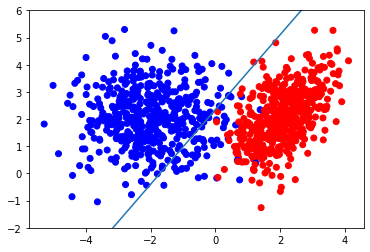

In [18]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

If you run optimization several times you will see that convegence to the ideal classification boundary is not always good. This is because MSE loss function is not very suited for classifiction, since it will always be in 0-1 interval. In other words, sigmoid "hides" the information on how bad our original error was - because it converges to 0 or 1 asymptotically when the output of linear function becomes too big or too small. 

To compensate for that, we can use logarithmic loss function. For example, if the expected class is $\hat y=1$, and our model gives the value $y=0.1$ after the sigmoid function, the loss would be $-\log 0.1\approx 2.3$. And if predicted value of $y$ goes closer to 0, logarithm would increase even faster! However, if we guessed the class correctly and predicted 1, our loss would be 0.

> Output of the model (after sigmoid) can be thought of as a **probability** that the predicted class is 1. 


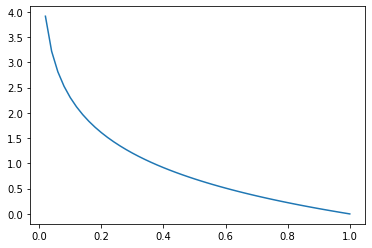

In [19]:
nx = np.linspace(0.1,5)/5
plt.plot(nx,-np.log(nx))
plt.show()

Similarly, for the expected value of $\hat y=0$ the loss would be $-\log(1-y)$, where $y$ is our model output. So, if we denote the expected value as $\hat y \in\{0,1\}$, our logistic loss function would be
$$
\mathrm{logloss}(y,\hat y) = -\hat y\log y - (1-\hat y)\log(1-y)
$$

> For more general case, if we have $n>2$ classes, our expected class is $\hat y=i$, and the probability for the $i$-th class predicted by the model is $p_i$ ($\sum_k p_k=1$), the logistic loss would be given by $-\log p_{i}$

Let's try our optimization loop with logistic loss function. In this example, we come back to using pre-computed derivatives for $W$ and $b$:

In [26]:
W = np.random.normal(size=(2,))
b = np.random.normal(size=(1,))

def loss(W, b):
    h = sigmoid(np.matmul(X,W)+b)
    return (-Y * np.log(h) - (1 - Y) * np.log(1 - h)).mean()

eta = 0.2
n = len(X)
for i in range(100):
    print(f"({W} {b}) -> loss={loss(W,b)}")
    #print(f"dldw={dldw}, dldb={dldb}, W={W}, b={b}")

    h = sigmoid(np.matmul(X,W)+b)
    dldw = np.matmul(X.T,h-Y.T)/n
    dldb = (h-Y.T).mean()
    W-=eta*dldw
    b-=eta*dldb


([-0.97897428  1.0819612 ] [0.69877229]) -> loss=2.6383820146522283
([-0.71651405  0.93339243] [0.63230949]) -> loss=2.1666863214215226
([-0.46577955  0.77993417] [0.56347576]) -> loss=1.7177091459994842
([-0.22752862  0.62563064] [0.4943758]) -> loss=1.3020346616862912
([-0.00586074  0.47657268] [0.42818676]) -> loss=0.9420409491547693
([0.19052225 0.34239531] [0.36953342]) -> loss=0.6675686044922461
([0.35228064 0.23388726] [0.32288857]) -> loss=0.48984060723974826
([0.4794725  0.15405564] [0.2888673]) -> loss=0.3850662555730145
([0.58069992 0.09676292] [0.26446714]) -> loss=0.32165181967412115
([0.66425139 0.05464428] [0.24648545]) -> loss=0.28016000106456
([0.73555305 0.0225301 ] [0.23273696]) -> loss=0.2509188192038739
([ 0.79795945 -0.00282073] [0.22185996]) -> loss=0.22907967152047043
([ 0.85361289 -0.02344083] [0.21299949]) -> loss=0.21204132394981673
([ 0.90395027 -0.04064229] [0.20560165]) -> loss=0.19830225290458822
([ 0.94998091 -0.05530094] [0.19929506]) -> loss=0.18693778

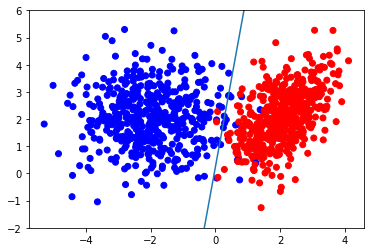

In [27]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

## Classification in SkLearn

In most of the practical cases, we will use Scikit Learn to train classification models. Let's split our data into train/test dataset and see the accuracy:

In [44]:
import sklearn.linear_model
import sklearn.preprocessing

X_train,X_test,Y_train,Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

model = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_pred)}")

Accuracy=0.975


We can also compute the accuracy manually in this manner:

In [34]:
1-np.mean(np.abs(Y_test-Y_pred))

0.985

We can also predict probabilities for individual classes:

In [37]:
model.predict_proba(X_test[:5])

array([[1.84620780e-03, 9.98153792e-01],
       [4.66260078e-03, 9.95337399e-01],
       [9.99748926e-01, 2.51073923e-04],
       [9.98742209e-01, 1.25779112e-03],
       [9.99564821e-01, 4.35178919e-04]])

Let's see how the boundary line looks like:

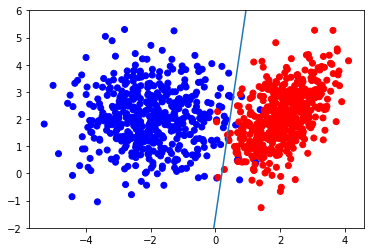

In [45]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
b = model.intercept_
W = model.coef_[0]
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

Now let's come back to real-life classification problem using Titanic dataset:

In [47]:
import pandas as pd
df = pd.read_csv("../../data/titanic.csv")
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,Allen. Miss. Elisabeth Walton,female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,St Louis. MO
1,1,1,Allison. Master. Hudson Trevor,male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,Montreal. PQ / Chesterville. ON
2,1,0,Allison. Miss. Helen Loraine,female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,Montreal. PQ / Chesterville. ON
3,1,0,Allison. Mr. Hudson Joshua Creighton,male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,Montreal. PQ / Chesterville. ON
4,1,0,Allison. Mrs. Hudson J C (Bessie Waldo Daniels),female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,Montreal. PQ / Chesterville. ON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,Zabour. Miss. Hileni,female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,Zabour. Miss. Thamine,female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,Zakarian. Mr. Mapriededer,male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,Zakarian. Mr. Ortin,male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


First of all, we need to vectorize categorical data. Let's start with sex. It is nominal, but since there are only two values, it does not really matter whether we treat it as nominal or ordinal, i.e. if we use Label Encoding or One-Hot Encoding.

In [48]:
df["nsex"] = df['sex'].apply(lambda x: 0 if x=="male" else 1)

We can notice that some values are missing for `age` column. Let's see how many:

In [50]:
df['age'].isna().sum()

263

There are several possible options for handling missing values:
* Remove all rows with missing values. It is not the ideal solution, because in our case we have more than 10% such lines.
* Remove the whole `age` column. Also not a good solution, because it has important predictive power.
* Fill all missing values with some value, eg. mean:

In [51]:
df['fage'] = df['age'].fillna(df['age'].mean())
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,nsex,fage
0,1,1,Allen. Miss. Elisabeth Walton,female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,St Louis. MO,1,29.000000
1,1,1,Allison. Master. Hudson Trevor,male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,Montreal. PQ / Chesterville. ON,0,0.916700
2,1,0,Allison. Miss. Helen Loraine,female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,Montreal. PQ / Chesterville. ON,1,2.000000
3,1,0,Allison. Mr. Hudson Joshua Creighton,male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,Montreal. PQ / Chesterville. ON,0,30.000000
4,1,0,Allison. Mrs. Hudson J C (Bessie Waldo Daniels),female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,Montreal. PQ / Chesterville. ON,1,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,Zabour. Miss. Hileni,female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN,1,14.500000
1305,3,0,Zabour. Miss. Thamine,female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN,1,29.881135
1306,3,0,Zakarian. Mr. Mapriededer,male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN,0,26.500000
1307,3,0,Zakarian. Mr. Ortin,male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN,0,27.000000


Now that we have cleaned our dataset, we can do the train-test split:

In [52]:
features = ['pclass','nsex','fage','sibsp','parch']
X = df[features]
Y = df['survived']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

Let's train the model:

In [53]:
model = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_pred)}")

Accuracy=0.7366412213740458


To understand in more detail how the error looks like, we can look at **confusion matrix**:

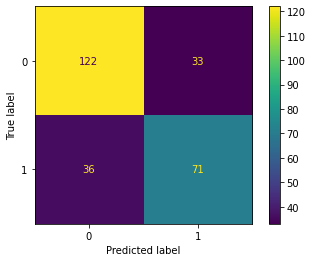

In [54]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,Y_test)
plt.show()

For classification, we can also measure other metrics:

In [55]:
print(sk.metrics.classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       155
           1       0.68      0.66      0.67       107

    accuracy                           0.74       262
   macro avg       0.73      0.73      0.73       262
weighted avg       0.74      0.74      0.74       262



Let's also have a look at ROC-curve and AUC value: 

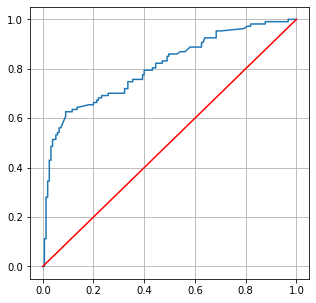

In [58]:
fpr, tpr, thresholds = sk.metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr)
plt.grid()
plt.plot([0,1],[0,1],c='r')

In [57]:
sk.metrics.auc(fpr,tpr)

0.8063008742839913

Also, let's try to interpret our model by looking at coefficients:

In [59]:
list(zip(['pclass','nsex','fage','sibsp','parch'],model.coef_[0]))

[('pclass', -1.1611854954682355),
 ('nsex', 2.5842502299024956),
 ('fage', -0.040272935625449764),
 ('sibsp', -0.3227114045114366),
 ('parch', 0.0004373627706573993)]

<BarContainer object of 5 artists>

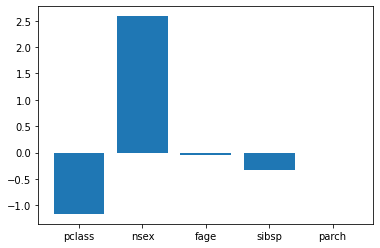

In [60]:
plt.bar(['pclass','nsex','fage','sibsp','parch'],model.coef_[0])

## Decision Trees

Unlike linear models, decision trees work best for categorical value. A simples algorithm to build a decision tree is called [ID3](https://ru.wikipedia.org/wiki/ID3_(%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC).

Let's consider only categorical attribues of our model, eg `sex` and `pclass`. Let's also convert `age` to categorical attribute by **binning**:


In [ ]:
df['agecat'] = df['age'].apply(lambda x: "young" if x<18 else "old" if x>45 else "middle")

Suppose we want to use only `sex` for classification. Let's compute probabilities for different genders separately:

In [ ]:
for s in df['sex'].unique():
    print(f"Probability for sex={s} is {df[df['sex']==s]['survived'].mean()}")

So we can predict survived=1 for all women, and survived=0 for all men and that would give us certain accuracy.

However, what if looking at `pclass` would give us better predictive power? Let's try out all features and see, using which has better predictive power:

In [ ]:
def accuracy_by_attr(df,attr):
    p = {}
    for k in df[attr].unique():
        p[k] = int(df[df[attr]==k]['survived'].mean()>=0.5)
    return df.apply(lambda x: p[x[attr]]==x['survived'],axis=1).mean()

for a in ['pclass','sex','agecat']:
    print(f"Accuracy by {a} = {accuracy_by_attr(df,a)}")

So, looking at `sex` is the most effective. After that, we can split the dataset into two parts, and for each of them repeat the process. Here's how accuracy will look like if we then classify by `pclass`, for men and women separately:

In [ ]:
for sex in ['male','female']:
    df_1 = df[df['sex']==sex]
    print(f"{sex}, accuracy by pclass = {accuracy_by_attr(df_1,'pclass')}")

ID3 works with categorical attributes only. There is also more advanced version of the algorithm called [С4.5](https://ru.wikipedia.org/wiki/C4.5), developed by the same author. It supports branch pruning, using numerical attributed (i.e. automatic boundary selection in the same manner, as we did with age), and also working with missing values.

Let's use decision tree algorithm from SkLearn:

In [ ]:
import sklearn.tree 

model = sk.tree.DecisionTreeClassifier().fit(X_train,Y_train)
Y_pred = model.predict(X_test)
sk.metrics.accuracy_score(Y_test,Y_pred)

As you can see, the accuracy more or less corresponds to linear model. Depending on the problem, however, we can sometimes get very different results - that is why Automatic ML approach that we have seen before is used to try our different models for any given dataset.

Tree models are good, because they are interpretable. Let's try to train a shallow tree and see how it looks like:

In [ ]:
model = sk.tree.DecisionTreeClassifier(max_depth=3).fit(X_train,Y_train)

import graphviz
graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'

graphviz.Source(
    sk.tree.export_graphviz(model,feature_names=features,class_names=['no','yes'],
    filled=True, rounded=True, special_characters=True,impurity=False)
)

We can see that, as in our investigation above, `sex` is most important factor at the root of the tree, and then more complex logic is used

### Support Vector Machine (SVM)

Let's talk about one more linear classification model - support vector machine, or SVM. Consider again the 2D case:

In [ ]:
X,Y = sk.datasets.make_classification(
    n_samples=1000,n_features=2,random_state=3,
    n_informative=2,n_redundant=0,
    class_sep=2,n_clusters_per_class=1,flip_y=0)

plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
plt.show()

The idea of SVM is to build such an ideal separation line $w_0x_0+w_1x_1+b=0$, that yields the widest **separation margin** between two classes. By varying the angle of the separation line we can vary the margin. Elements through which lines parallel to the separation line passes are called **support vectors**:

In [ ]:
import sklearn.svm, sklearn.inspection

model = sk.svm.SVC(kernel="linear", C=1000)
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()
# build the separaton line
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)
# highlight the support vectors
ax.scatter(
    model.support_vectors_[:, 0], model.support_vectors_[:, 1],
    s=100, linewidth=1, facecolors="none", edgecolors="k")

plt.show()

This method is in a way similar to logistic regression, but uses different loss function that maximizes the margin. Since we are mostly using support vectors and now all dataset elements to build our separation line (or hyperplane for higher-dimensional cases), the method turns our to be more efficient for large datasets.

To separate classes that are not linearly separable, SVM allows using so-called **kernel trick**, by using non-linear **kernel functions**. For example, if we use SVM from Scikit Learn with default parameters, it will use non-linear kernel functions: 

In [ ]:
import sklearn.svm, sklearn.inspection

model = sk.svm.SVC()
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()
# showing separation lines
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)
# highlight support vectors
ax.scatter(
    model.support_vectors_[:, 0], model.support_vectors_[:, 1],
    s=100, linewidth=1, facecolors="none", edgecolors="k")

plt.show()

Let's see a set of two classes that are not linearly separable. We can use `make_circles` function to generate those:

In [ ]:
X,Y = sk.datasets.make_circles(n_samples=100,factor=0.5,noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])
plt.show()

Let's apply SVM with non-linear kernel:

In [ ]:
model = sk.svm.SVC()
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()

sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)

plt.show()

Let's see how accuracy changes when using linear and non-linear models:

In [ ]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

linmodel = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

print(f"Linear accuracy = {sk.metrics.accuracy_score(Y_test,linmodel.predict(X_test))}")
print(f"Non-lin SVM accuracy = {sk.metrics.accuracy_score(Y_test,model.predict(X_test))}")

Let's not that we can achieve high accuracy by using linear model and adding extra computed features to our dataset:

In [ ]:
X_train_aug = np.hstack([X_train,X_train*X_train])
X_test_aug = np.hstack([X_test,X_test*X_test])

linaugmodel = sk.linear_model.LogisticRegression().fit(X_train_aug,Y_train)

print(f"Augmented linear accuracy = {sk.metrics.accuracy_score(Y_test,linaugmodel.predict(X_test_aug))}")


We can achieve the same result by automatically generating higher-order features using `PolynomialFeatures` transformer:

In [ ]:
import sklearn.pipeline

pipe = sk.pipeline.Pipeline([
    ('PolyTransformer',sk.preprocessing.PolynomialFeatures()),
    ('LinearModel',sk.linear_model.LogisticRegression())
])
pipe.fit(X_train,Y_train)
print(f"Pipeline accuracy = {sk.metrics.accuracy_score(Y_test,pipe.predict(X_test))}")


### Multi-Class Classifiction

 As an example of multi-class classification problem, let's consider handwritten digit recognition using [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)) dataset - a dataset of handwritten digits collected by US National Institute of Standards. Training dataset contains 60000 digits collected from 250 different students and employees of NIST, and the test dataset of 10000 digits, collected from different individuals. Each digit is represented by 28x28 pixel array in 256 grayscale levels.


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

X = mnist.data
Y = mnist.target
print(X.shape, Y.shape)

In [ ]:
fig,ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(X.iloc[i].to_numpy().reshape(28,28))
    ax[i].axis('off')
    ax[i].set_title(Y[i])
plt.show()

Whole dataset contains 70000 digits. Let's split it into training and test dataset. To speed things up, we will use only 10000 digits for both training and test. You can try to use the whole dataset, but be prepared to wait longer!

In [ ]:
X_train, X_test, Y_train, Y_test = \
  sk.model_selection.train_test_split(X,Y,train_size=10000, test_size=10000)

Classification algorithms that we have discussed above were **binary**. For multi-class we can use **one-vs-all** approach. Let's train a classifier to classify between 0 and non-0 digits:

In [ ]:
Y0_train = Y_train=="0"
Y0_test = Y_test==0
model = sk.linear_model.LogisticRegression().fit(X_train,Y0_train)
sk.metrics.accuracy_score(Y0_test,model.predict(X_test))

In some cases you may see that algorithm does not converge. It can be for several reasons:

* An optimized used by default in `LogisticRegression` is not expactly gradient descent, but `lbfgs`, which works well on relatively small datasets. You can try specifying different optimizer using `solver=...`.
* There is a convention that all input features are scaled to 0..1 interval (or something close to 0..1 or -1..1), and many libraries expect this. It is especially important for data where features have different scales (eg. person's height can vary fro 30 to 250 cm, and age - from 0 to 120), and it is important to scale all input values to the same interval to ensure *fair* training. Before we did not care too much about scaling 0..1, because we did not come across high dimensional problems. Our MNIST model has 768 inputs, and each of them can have values in 0..255 range, so adding all those inputs together can lead to pretty large numbers.

Let's normalize all values in the dataset:

In [ ]:
model = sk.linear_model.LogisticRegression(solver='newton-cg').fit(X_train/255.0,Y0_train)
sk.metrics.accuracy_score(Y0_test,model.predict(X_test/255.0))

So, we get nearly 90% accuracy for "0 vs all" classifier. For multiclass classification, we need to build 10 such models, one for each digit. Sklearn contains special class that allows us to convert any binary classifier to multi-class classifier automatically using **One vs. All** approach:

In [ ]:
import sklearn.multiclass

model = sk.multiclass.OneVsRestClassifier(
    sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1))
model.fit(X_train/255.0, Y_train)
sk.metrics.accuracy_score(Y_test,model.predict(X_test/255.0))

Let's see confusion matrix:

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_test/255.0,Y_test)
plt.show()

`OneVsRestClassifier` can convert any binary classifier to multiclass. However, many classfiers in SkLearn, including logistic regression, already support multi-class mode. Thus we can feed multi-class data directly into `LogisticRegression`:

In [ ]:
model = sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1)
model.fit(X_train/255.0, Y_train)
sk.metrics.accuracy_score(Y_test,model.predict(X_test/255.0))

It is interesting to look at the coefficients of the model. In multi-class case, the shape of `model.coef_` would be $10\times784$ - it corresponds to 10 classes, each having $768=28\times28$ coefficients. We can try and visualize it: 

In [ ]:
fig,ax = plt.subplots(1,10,figsize=(15,6))
for i in range(10):
    ax[i].imshow(model.coef_[i].reshape(28,28))
    ax[i].axis('off')
plt.show()

This picture explains how the classifier works - it multiplies the pattern from coefficient vector by the input image, and the output is higher when the pattern corresponds to the input image. Positive coefficients in the weight pattern correspond to those pixels that should be present for the digit being recognized, and negative - to the pixels that suggest that the digit is not the intended one.

### Cross-Validation

To test the accuracy of the model we have done train-test split. However, in this case one part of the dataset is "lost" and not used for training. Also, there is always a chance that this particular split is not ideal, and yields the results that are somehow higher or lower that the average.

To avoid thos problems, we can use **cross-validation** (*K-Fold Cross-Validation*). In this case, our dataset is split into $k$ parts, and $k$ training experiments are performed. During each experiment, one of the parts is used for validation (each time - different part), and the rest for training. Obtained metric results are then averaged out.

Scikit Learn can train any model using cross-validation:

In [264]:
model = sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1)
scores = sk.model_selection.cross_val_score(model,X/255.0,Y,cv=5) 
scores

array([0.92192857, 0.92128571, 0.91521429, 0.91828571, 0.92978571])

In [265]:
scores.mean(), scores.std()

(0.9212999999999999, 0.004868767601681531)

In `cross_val_score` method we can speficy different metrics to be estimated, and also different strategies for splitting the dataset (using `cv` parameter).

There is also a method called `cross_val_predict`, which returns the predicted value for each element in the dataset, predicted by the model which as not been trained on that element.

If we need to returned actual trained models during cross-validation, we need to use `cross_validate` method. More about it can be found [in documentation](https://scikit-learn.org/stable/modules/cross_validation.html).